In [1]:
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
import ClusterEnsembles as CE
from sklearn.metrics import normalized_mutual_info_score

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster, cophenet

## HCAS and Combining (with CSPA consensus function)

#### a. Full ensemble (J = 300) [Done: Y_CSPA_EN ]

#### b. Bagging (J = (1,101,1)
* Quality index used NMI

#### c.  Single quality index (SQI) (J = (1,101,1)
* Q1-SNMI-ranked
* Q2-Silhouette-ranked

#### d. HCAS-SQI (Hierarchical cluster and select with single quality index)
* HCAS-SNMI
* HCAS-Silhouette

#### e. HCAS-MQI (Hierarchical cluster and select with multiple quality indices)
* HCAS-DC (direct combining) (J = Union of two subsets)
* HCAS-WC (weighted combining) (J = (1,101,1)
* HCAS-BC (bagging combining) (J = (1,101,1)


In [2]:
dataset_path = '/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/CES Data/Project 3 IR+Raman Data/'
output_path = '/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/CES ML results/Project 3 IR+Raman Results/'

In [3]:
def get_matrix(df):
    index = df.index[0:300]
    df_Similarity_matrix = pd.DataFrame(0,index=index, columns=index)
    for i in range(300):
        for j in range(300):
            df_Similarity_matrix.iloc[i,j] = normalized_mutual_info_score(df.iloc[i,:],df.iloc[j,:])
    return df_Similarity_matrix

In [4]:
def get_HCAS_n(df,method):
    X = df.values
    print("Linkage method = ", method)
    Z = linkage(X,method=method)
    
    df_tmp = df_BC_quality_merge.copy()
    
    df_tmp[str(method)+"_k_"+str(100)]=fcluster(Z,t=100,criterion='maxclust').tolist()

    print("Done")
    
    return df_tmp

In [5]:
def bagging_ranking(df_full_ensemble):
    print("There are ",df_full_ensemble.shape[0], "ensemble members to be bagged")
    Full_EN_Members=df_full_ensemble.index
    n_bagged = int(df_full_ensemble.shape[0]/2)
    print("Each bagging will randomly select", n_bagged, " ensemble members to compute a consensus solution")
    print("Bagging will repeat 50 times")
    
    # Create an empty dataframe for saving different ranking solutions
    df_BC_results = pd.DataFrame(index=Full_EN_Members)
    
    for t in range(0, 50):
        # Random sample half of full ensemble and create a consensus partition using the consensus function
        EN_half = df_full_ensemble.loc[np.random.choice(Full_EN_Members,n_bagged,replace=True)]
        Y_EN_half = CE.cluster_ensembles(EN_half.values, solver = "cspa", verbose=False, nclass = 16, random_state=42)
        
        # Create empty list for saving NMI value between half EN consensus solution and each ensemble member
        NMI = []
        for member in Full_EN_Members:
            #print("Calculate NMI value between half EN consensus solution and each member:", member)
            NMI.append(normalized_mutual_info_score(Y_EN_half,df_full_ensemble.loc[member]))
        df_BC_results['rank_'+str(t+1)]=NMI
        
    df_ranked = df_BC_results.rank(method="first",ascending=False)
    df_ranked["final_rank"]=df_ranked.mean(axis=1)
    df_ranked = df_ranked.sort_values(by=['final_rank'])
    
    return df_ranked

In [6]:
def get_member_subset_w(subset):
    #print(subset.index)
    selected_member_Distor = df_BC_quality_merge.loc[subset.index]['Distor']
    min_Distor = min(selected_member_Distor)
    A_sum_Distor = sum(selected_member_Distor)/len(selected_member_Distor)
    
    w = []
    for member in (selected_member_Distor.index):
        #print(member)
        member_Distor = selected_member_Distor[member]
        member_w = np.exp((-member_Distor-min_Distor)/A_sum_Distor)
        #print(member_w)
        w.append(member_w)
    subset_w = sum(w)/100
    
    df_subset=pd.DataFrame(w,index=selected_member_Distor.index)
    return df_subset, subset_w

def get_df_WC(Subsets):
    G=len(Subsets)
    print(G," subsets to be combined by weighted combining strategy")
    
    df_WC_tmp = pd.DataFrame(index=df_BC_quality_merge.index)

    subset_Weights=[]
    for subset in Subsets:
        df_subset, subset_Weight = get_member_subset_w(subset)
        df_WC_tmp = pd.concat([df_WC_tmp,df_subset],axis=1)
        subset_Weights.append(subset_Weight)

    df_WC_tmp = df_WC_tmp.fillna(0)
    
    max_subset_Weight = max(subset_Weights)
    A_sum_subset_Weight = sum(subset_Weights)/G
    
    norm_subset_Weights = []
    for subset_Weight in subset_Weights:
        norm_subset_Weight = np.exp((subset_Weight-max_subset_Weight)/A_sum_subset_Weight)
        norm_subset_Weights.append(norm_subset_Weight)
        
    for g in range(G):
        df_WC_tmp.iloc[:,g] = df_WC_tmp.iloc[:,g]*norm_subset_Weights[g]
    
    df_WC_tmp["final_W"]= df_WC_tmp.sum(axis=1)
    df_WC_tmp = df_WC_tmp.sort_values(by=['final_W'],ascending=False)
    df_WC_tmp=df_WC_tmp[df_WC_tmp['final_W']!=0]
    return df_WC_tmp

In [7]:
def create_subset(J, df_rank_sorted):
    df = df_result_merge.iloc[0:300]
    
    set_idx = df_rank_sorted.iloc[0:J].index
    #print(set_idx)
    subset=df.loc[set_idx]
    #print(subset)
        
    non_set = df.drop(set_idx,axis=0)
    #print(non_set.shape[0])

    return subset, non_set

In [8]:
def Dominant_ratio(subset, non_subset):
    
    Y1 = CE.cluster_ensembles(subset.values, solver = "cspa", verbose=False, nclass = 16, random_state=42)
    Y2 = CE.cluster_ensembles(non_subset.values, solver = "cspa", verbose=False, nclass = 16, random_state=42)
    
    NMI1 = normalized_mutual_info_score(Y,Y1)
    NMI2 = normalized_mutual_info_score(Y,Y2)
    
    return NMI1, NMI1/NMI2

In [9]:
Qs = ["SNMI","Silhouette"]
CES_Methods = ["Bagging", "SQI-SNMI", "SQI-Silhouette", "HCAS-SQI-SNMI", "HCAS-SQI-Silhouette", "HCAS-MQI-WC", "HCAS-MQI-BC"]

row_index = ['Bagging_NMI',
             'Bagging_Dominant_ratio',
             'SQI_SNMI_NMI',
             'SQI_SNMI_Dominant_ratio',
             'SQI_Silhouette_NMI',
             'SQI_Silhouette_Dominant_ratio',
             'HCAS_SQI_SNMI_NMI',
             'HCAS_SQI_SNMI_Dominant_ratio',
             'HCAS_SQI_Silhouette_NMI',
             'HCAS_SQI_Silhouette_Dominant_ratio',
             'HCAS_MQI_WC_NMI',
             'HCAS_MQI_WC_Dominant_ratio',
             'HCAS_MQI_BC_NMI',
             'HCAS_MQI_BC_Dominant_ratio']

In [153]:
filename="0.971 scaled DFT 6-311++G(d,p) IR dataset"
run_i = "run_20"

df_result_merge = pd.read_csv(output_path+filename+" BC library "+run_i+".csv", index_col="Unnamed: 0")
Y_CSPA_EN = df_result_merge.loc["CSPA_EN"]

df = pd.read_csv(dataset_path+filename+".csv")
Y=df.Class

df_BC_quality_merge = pd.read_csv(output_path+filename+" BC library quality indices "+run_i+".csv",index_col="BC_run")


NMI_CSPA_EN = normalized_mutual_info_score(Y,Y_CSPA_EN)
print("Method a, consensus solution using full ensemble and cspa consensus function:",NMI_CSPA_EN)

NMI_Average = df_BC_quality_merge['NMI_Y'].mean()
print("Baseline performance, the average NMI of all ensemble members:", NMI_Average)

Method a, consensus solution using full ensemble and cspa consensus function: 0.6328833925963918
Baseline performance, the average NMI of all ensemble members: 0.5296656966250559


#### Step 1. Create ensemble ranking for 
##### b. Bagging: [df_Bagging_EN_ranked]

In [154]:
df_Bagging_EN_ranked = bagging_ranking(df_result_merge.iloc[0:300])

There are  300 ensemble members to be bagged
Each bagging will randomly select 150  ensemble members to compute a consensus solution
Bagging will repeat 50 times


##### c. Single quality index (SQI)
* c.1 SNMI: [df_SNMI_ranked]
* c.2 Silhouette: [df_Silhouette_ranked]

In [155]:
df_SNMI_ranked = df_BC_quality_merge.sort_values(by = [Qs[0]],ascending=False)
df_Silhouette_ranked = df_BC_quality_merge.sort_values(by = [Qs[1]],ascending=False)

#### Step 2. Create HCAS-SQI subset with 100 ensemble members
Hierarchical linkage method = 'ward'

d. HCAS-SQI
* d.1 SNMI: df_HCAS_SNMI
* d.2 SNMI: df_HCAS_Silhouette

In [156]:
df_S = get_matrix(df_result_merge)

df_HCAS = get_HCAS_n(df_S,'ward')

df_HCAS_SNMI = df_HCAS.sort_values(by = ["ward_k_100", Qs[0]], ascending = [True, False]).drop_duplicates(subset=["ward_k_100"],keep='first').sort_values(by=[Qs[0]],ascending=False)

df_HCAS_Silhouette = df_HCAS.sort_values(by = ["ward_k_100", Qs[1]], ascending = [True, False]).drop_duplicates(subset=["ward_k_100"],keep='first').sort_values(by=[Qs[1]],ascending=False)

Linkage method =  ward
Done


#### Step 3. Create HCAS-MQI using direct combining (DC)
* e.1 HCAS-DC: HCAS_MQI_DC_NMI, HCAS_MQI_DC_Dominant_ratio

In [157]:
df_DC_subset = df_result_merge.iloc[0:300].loc[set(df_HCAS_SNMI.index).union(set(df_HCAS_Silhouette.index))]
df_DC_non_subset = df_result_merge.iloc[0:300].drop(set(df_HCAS_SNMI.index).union(set(df_HCAS_Silhouette.index)),axis=0)
print("There are ", df_DC_subset.shape[0], "ensemble members in the HCAS-DC final subset")


HCAS_MQI_DC_NMI, HCAS_MQI_DC_Dominant_ratio = Dominant_ratio(df_DC_subset, df_DC_non_subset)
print("HCAS-DC final reduced subset NMI is %0.3f and Dominant ratio is %0.2f" %(HCAS_MQI_DC_NMI, HCAS_MQI_DC_Dominant_ratio))

There are  135 ensemble members in the HCAS-DC final subset
HCAS-DC final reduced subset NMI is 0.583 and Dominant ratio is 0.95


Save HCAS-MQI-DC consensus result is saved to df_result_merge

In [158]:
df_result_merge.loc['HCAS_DC_subset'] = CE.cluster_ensembles(df_DC_subset.values, solver = "cspa", verbose=False, nclass = 16, random_state=42)
df_result_merge.loc['HCAS_DC_non_subset'] = CE.cluster_ensembles(df_DC_non_subset.values, solver = "cspa", verbose=False, nclass = 16, random_state=42)

df_result_merge.to_csv(output_path+filename+" BC library "+run_i+".csv")

#### Step 4. Create HCAS-BC and HCAS-WC ranking
* e.2 HCAS-BC:[df_BC_ranked]
* e.3 HCAS-WC:[df_WC_ranked]

In [159]:
df_BC_ranked = bagging_ranking(df_DC_subset)

Subsets = [df_HCAS_SNMI,df_HCAS_Silhouette]

df_WC_ranked = get_df_WC(Subsets)

There are  135 ensemble members to be bagged
Each bagging will randomly select 67  ensemble members to compute a consensus solution
Bagging will repeat 50 times
2  subsets to be combined by weighted combining strategy


#### Step 5. Final comparison for performance!!!

In [160]:
Final_Subsets = [df_Bagging_EN_ranked, df_SNMI_ranked, df_Silhouette_ranked, df_HCAS_SNMI, df_HCAS_Silhouette, df_WC_ranked, df_BC_ranked]

J=range(5,105,5)
df_Final_Comparison = pd.DataFrame(index=row_index,columns=J)

row_j=0
CES_counter = 0
for subset in Final_Subsets:
    print("Evaluating ", CES_Methods[CES_counter], " CES Method")
    
    NMI_subset, Dominant_ratio_subset = [],[]
    for i in J:
        #print(i)
        final_subset, final_non_subset = create_subset(i, subset)
        final_subset_NMI, final_subset_Dominant_ratio = Dominant_ratio(final_subset, final_non_subset)
        NMI_subset.append(final_subset_NMI)
        Dominant_ratio_subset.append(final_subset_Dominant_ratio)
    df_Final_Comparison.iloc[row_j]=NMI_subset
    row_j +=1
    print(row_j)
    df_Final_Comparison.iloc[row_j]=Dominant_ratio_subset
    row_j +=1
    print(row_j)
    print(CES_Methods[CES_counter], " CES Method is done")
    CES_counter += 1
print("Done")

Evaluating  Bagging  CES Method
1
2
Bagging  CES Method is done
Evaluating  SQI-SNMI  CES Method
3
4
SQI-SNMI  CES Method is done
Evaluating  SQI-Silhouette  CES Method
5
6
SQI-Silhouette  CES Method is done
Evaluating  HCAS-SQI-SNMI  CES Method
7
8
HCAS-SQI-SNMI  CES Method is done
Evaluating  HCAS-SQI-Silhouette  CES Method
9
10
HCAS-SQI-Silhouette  CES Method is done
Evaluating  HCAS-MQI-WC  CES Method
11
12
HCAS-MQI-WC  CES Method is done
Evaluating  HCAS-MQI-BC  CES Method
13
14
HCAS-MQI-BC  CES Method is done
Done


In [161]:
df_Final_Comparison.to_csv(output_path+filename+" CES strategies final comparison "+run_i+".csv")

In [ ]:
print("NMI")
num=range(5,105,5)
fig = plt.figure(figsize=(6,4), dpi=300)
plt.rc('font', family='serif', size = 8)

plt.xlabel('Size of selected subset',fontsize=10)
plt.ylabel('NMI',fontsize=10)
plt.xlim(5,100,5)
plt.plot(num,df_Final_Comparison.loc["Bagging_NMI"], label = "Bagging", color="black",marker="+",ms=6)
plt.plot(num,df_Final_Comparison.loc["SQI_SNMI_NMI"], label = "SQI-SNMI", linestyle="--",color="#1f77b4")
plt.plot(num,df_Final_Comparison.loc["SQI_Silhouette_NMI"], label = "SQI-Silhouette", linestyle="--",color="#ff7f0e")
plt.plot(num,df_Final_Comparison.loc["HCAS_SQI_SNMI_NMI"], label = "HCAS-SQI-SNMI", color="#1f77b4")
plt.plot(num,df_Final_Comparison.loc["HCAS_SQI_Silhouette_NMI"], label = "HCAS-SQI-Silhouette", color="#ff7f0e")
plt.plot(num,df_Final_Comparison.loc["HCAS_MQI_WC_NMI"], label = "HCAS-MQI-WC", color="green")
plt.plot(num,df_Final_Comparison.loc["HCAS_MQI_BC_NMI"], label = "HCAS-MQI-BC", color="#820000")

plt.axhline(y=NMI_CSPA_EN, color="r", linestyle="--")
plt.axhline(y=HCAS_MQI_DC_NMI, color="#ffca13", linestyle="-.")
plt.axhline(y=NMI_Average, color="black", linestyle=":")

legend = plt.legend(loc='lower right', shadow=False, fontsize=8,ncol=3)
plt.show()

In [ ]:
print("Dominant ratio")
num=range(5,105,5)
fig = plt.figure(figsize=(6,4), dpi=300)
plt.rc('font', family='serif', size = 8)

plt.xlabel('Size of selected subset',fontsize=10)
plt.ylabel('Dominant ratio',fontsize=10)
plt.xlim(5,100,5)
plt.ylim(0.82,1.15,0.1)
plt.plot(num,df_Final_Comparison.loc["Bagging_Dominant_ratio"], label = "Bagging", color="black",marker="+",ms=6)
plt.plot(num,df_Final_Comparison.loc["SQI_SNMI_Dominant_ratio"], label = "SQI-SNMI", linestyle="--",color="#1f77b4")
plt.plot(num,df_Final_Comparison.loc["SQI_Silhouette_Dominant_ratio"], label = "SQI-Silhouette", linestyle="--",color="#ff7f0e")
plt.plot(num,df_Final_Comparison.loc["HCAS_SQI_SNMI_Dominant_ratio"], label = "HCAS-SQI-SNMI", color="#1f77b4")
plt.plot(num,df_Final_Comparison.loc["HCAS_SQI_Silhouette_Dominant_ratio"], label = "HCAS-SQI-Silhouette", color="#ff7f0e")
plt.plot(num,df_Final_Comparison.loc["HCAS_MQI_WC_Dominant_ratio"], label = "HCAS-MQI-WC", color="green")
plt.plot(num,df_Final_Comparison.loc["HCAS_MQI_BC_Dominant_ratio"], label = "HCAS-MQI-BC", color="#820000")

plt.axhline(y=1.00, color="r", linestyle="--")
plt.axhline(y=HCAS_MQI_DC_Dominant_ratio, color="#ffca13", linestyle="-.")

legend = plt.legend(loc='lower right', shadow=False, fontsize=8,ncol=3)
plt.show()

### Merge i_runs results

In [21]:
def get_final_average(n):
    df = pd.read_csv(dataset_path+filename+".csv")
    Y=df.Class
    
    Average_NMI_HCAS_MQI_DC = 0
    Average_Ratio_HCAS_MQI_DC = 0
    Average_NMI_CSPA_EN = 0
    Average_NMI_Y = 0
    runs = []
    for i in range(n):
        print("run_"+str(i+1))
        
        result_i = pd.read_csv(output_path+filename+" BC library run_"+str(i+1)+".csv", index_col="Unnamed: 0")
        Y_CSPA_EN = result_i.loc["CSPA_EN"]
        Average_NMI_CSPA_EN += normalized_mutual_info_score(Y,Y_CSPA_EN)
        
        NMI1 = normalized_mutual_info_score(Y,result_i.loc["HCAS_DC_subset"])
        Average_NMI_HCAS_MQI_DC += NMI1
        NMI2 = normalized_mutual_info_score(Y,result_i.loc["HCAS_DC_non_subset"])
        Average_Ratio_HCAS_MQI_DC += NMI1/NMI2
        
        quality_i = pd.read_csv(output_path+filename+" BC library quality indices run_"+str(i+1)+".csv",index_col="BC_run")
        NMI_Y = quality_i['NMI_Y'].mean()
        Average_NMI_Y += quality_i['NMI_Y'].mean()
        
        run_i = pd.read_csv(output_path+filename+" CES strategies final comparison run_"+str(i+1)+".csv",index_col="Unnamed: 0")
        runs.append(run_i)
    
    print("Total of ", len(runs), "iterations to avearge")
    df_concat=pd.concat(runs)
    unique_index = df_concat.index.unique()
    
    average = []
    for index in unique_index:
        average.append(df_concat.loc[index].mean())
        
    df_final_average = pd.DataFrame(average,index=unique_index)
    
    return df_final_average, Average_NMI_Y/n, Average_NMI_CSPA_EN/n, Average_NMI_HCAS_MQI_DC/n, Average_Ratio_HCAS_MQI_DC/n

In [22]:
filename="0.971 scaled DFT 6-311++G(d,p) IR dataset"
print(filename)
df_final_average, NMI_Average, NMI_CSPA_EN, HCAS_MQI_DC_NMI, HCAS_MQI_DC_Dominant_ratio = get_final_average(20)
df_final_average.to_csv(output_path+filename+" CES strategies final comparison compiled.csv")

0.971 scaled DFT 6-311++G(d,p) IR dataset
run_1
run_2
run_3
run_4
run_5
run_6
run_7
run_8
run_9
run_10
run_11
run_12
run_13
run_14
run_15
run_16
run_17
run_18
run_19
run_20
Total of  20 iterations to avearge


NMI


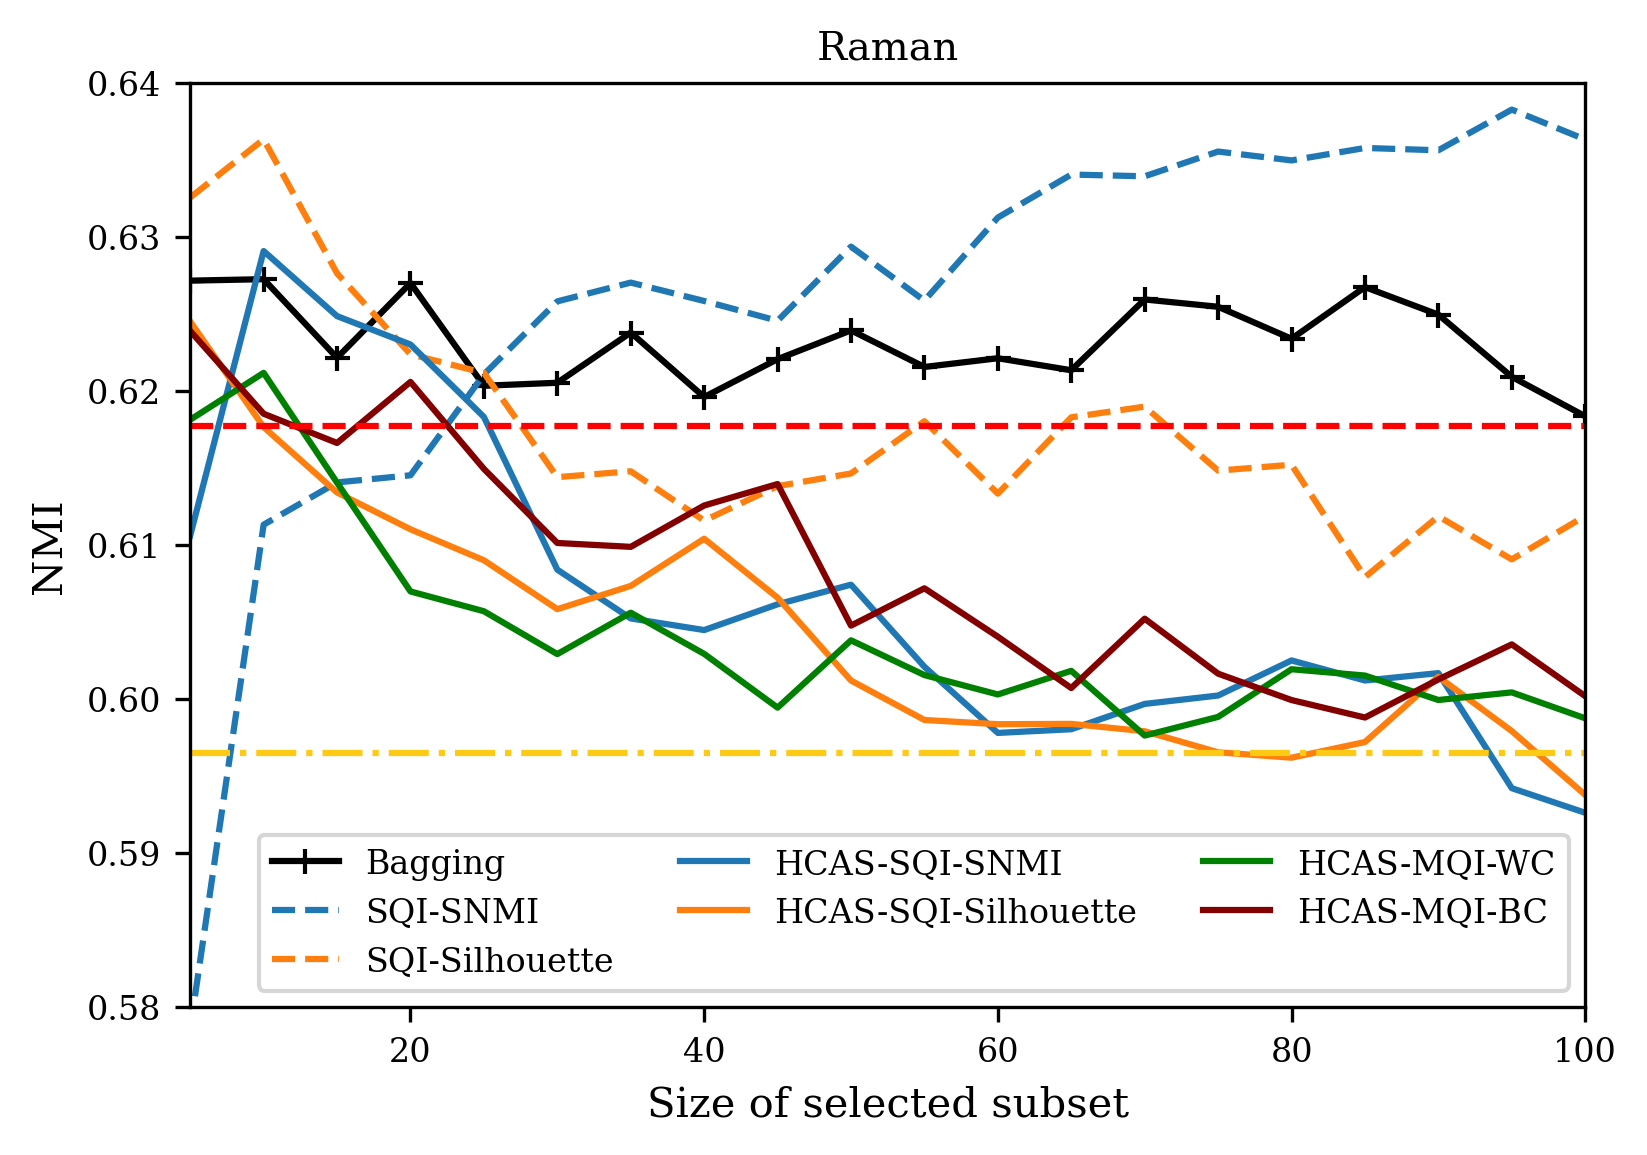

In [165]:
print("NMI")
num=range(5,105,5)
fig = plt.figure(figsize=(6,4), dpi=300)
plt.rc('font', family='serif', size = 8)

plt.xlabel('Size of selected subset',fontsize=10)
plt.ylabel('NMI',fontsize=10)
plt.title("Raman")
plt.xlim(5,100,5)
plt.ylim(0.58,0.64,0.01)
plt.plot(num,df_final_average.loc["Bagging_NMI"], label = "Bagging", color="black",marker="+",ms=6)
plt.plot(num,df_final_average.loc["SQI_SNMI_NMI"], label = "SQI-SNMI", linestyle="--",color="#1f77b4")
plt.plot(num,df_final_average.loc["SQI_Silhouette_NMI"], label = "SQI-Silhouette", linestyle="--",color="#ff7f0e")
plt.plot(num,df_final_average.loc["HCAS_SQI_SNMI_NMI"], label = "HCAS-SQI-SNMI", color="#1f77b4")
plt.plot(num,df_final_average.loc["HCAS_SQI_Silhouette_NMI"], label = "HCAS-SQI-Silhouette", color="#ff7f0e")
plt.plot(num,df_final_average.loc["HCAS_MQI_WC_NMI"], label = "HCAS-MQI-WC", color="green")
plt.plot(num,df_final_average.loc["HCAS_MQI_BC_NMI"], label = "HCAS-MQI-BC", color="#820000")

plt.axhline(y=NMI_CSPA_EN, color="r", linestyle="--")
plt.axhline(y=HCAS_MQI_DC_NMI, color="#ffca13", linestyle="-.")
#plt.axhline(y=NMI_Average, color="black", linestyle=":")

legend = plt.legend(loc='lower right', shadow=False, fontsize=8,ncol=3)
plt.show()
#fig.savefig(output_path+filename+" CES Strategies final comparison NMI.png", bbox_inches="tight", dpi = 300)

In [23]:
df_final_average

,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100
Bagging_NMI,0.627177,0.627272,0.622166,0.627020,0.620351,0.620545,0.623806,0.619619,0.622078,0.623948,0.621572,0.622137,0.621360,0.625954,0.625481,0.623402,0.626758,0.624969,0.620932,0.618370
Bagging_Dominant_ratio,1.004164,1.007586,1.001966,1.003535,1.006631,1.004330,1.011348,1.008557,1.008136,1.020941,1.016691,1.021601,1.025864,1.029712,1.026740,1.029917,1.035896,1.044748,1.041191,1.045809
SQI_SNMI_NMI,0.578581,0.611331,0.614075,0.614537,0.621087,0.625831,0.627050,0.625855,0.624572,0.629385,0.625882,0.631274,0.634066,0.633954,0.635559,0.634984,0.635793,0.635642,0.638285,0.636342
SQI_SNMI_Dominant_ratio,0.922722,0.984183,0.989086,0.989895,1.004816,1.010120,1.016450,1.016874,1.020612,1.029270,1.030124,1.051193,1.053649,1.058234,1.060389,1.067233,1.066163,1.077851,1.073270,1.078687
SQI_Silhouette_NMI,0.632576,0.636355,0.627652,0.622391,0.621188,0.614417,0.614798,0.611594,0.613834,0.614655,0.618051,0.613347,0.618304,0.618998,0.614841,0.615223,0.607922,0.611875,0.609076,0.611897
SQI_Silhouette_Dominant_ratio,1.013829,1.022150,1.003522,0.986870,0.988819,0.978934,0.989544,0.984069,0.989698,0.995257,1.008733,1.002526,1.012410,1.007545,1.008499,1.015022,1.004203,1.013502,1.015877,1.040331
HCAS_SQI_SNMI_NMI,0.610619,0.629098,0.624873,0.623032,0.618324,0.608409,0.605242,0.604488,0.606160,0.607436,0.602103,0.597809,0.598048,0.599691,0.600236,0.602515,0.601212,0.601691,0.594219,0.592623
HCAS_SQI_SNMI_Dominant_ratio,0.977516,1.010657,1.001908,0.993102,0.984514,0.979007,0.969822,0.969668,0.967728,0.972570,0.960399,0.957150,0.949234,0.958567,0.968741,0.972545,0.961142,0.958135,0.949973,0.949439
HCAS_SQI_Silhouette_NMI,0.624522,0.617667,0.613419,0.611030,0.609019,0.605846,0.607354,0.610419,0.606589,0.601209,0.598649,0.598374,0.598395,0.597917,0.596550,0.596200,0.597216,0.601456,0.597928,0.593783
HCAS_SQI_Silhouette_Dominant_ratio,1.004990,0.989163,0.974400,0.973155,0.979793,0.965119,0.960725,0.979073,0.967850,0.956812,0.959475,0.952142,0.952916,0.954864,0.947258,0.963369,0.959491,0.972199,0.959786,0.965511


In [24]:
print(max(df_final_average.loc['SQI_SNMI_NMI']))
print(max(df_final_average.loc['SQI_Silhouette_NMI']))
print(max(df_final_average.loc['Bagging_NMI']))
print(max(df_final_average.loc['HCAS_SQI_SNMI_NMI']))
print(max(df_final_average.loc['HCAS_SQI_Silhouette_NMI']))
print(max(df_final_average.loc['HCAS_MQI_WC_NMI']))
print(max(df_final_average.loc['HCAS_MQI_BC_NMI']))

0.6382848890519262
0.6363549881507923
0.627271787818334
0.6290982931122255
0.624521823582931
0.6211897369257742
0.6239100916394429


Dominant ratio


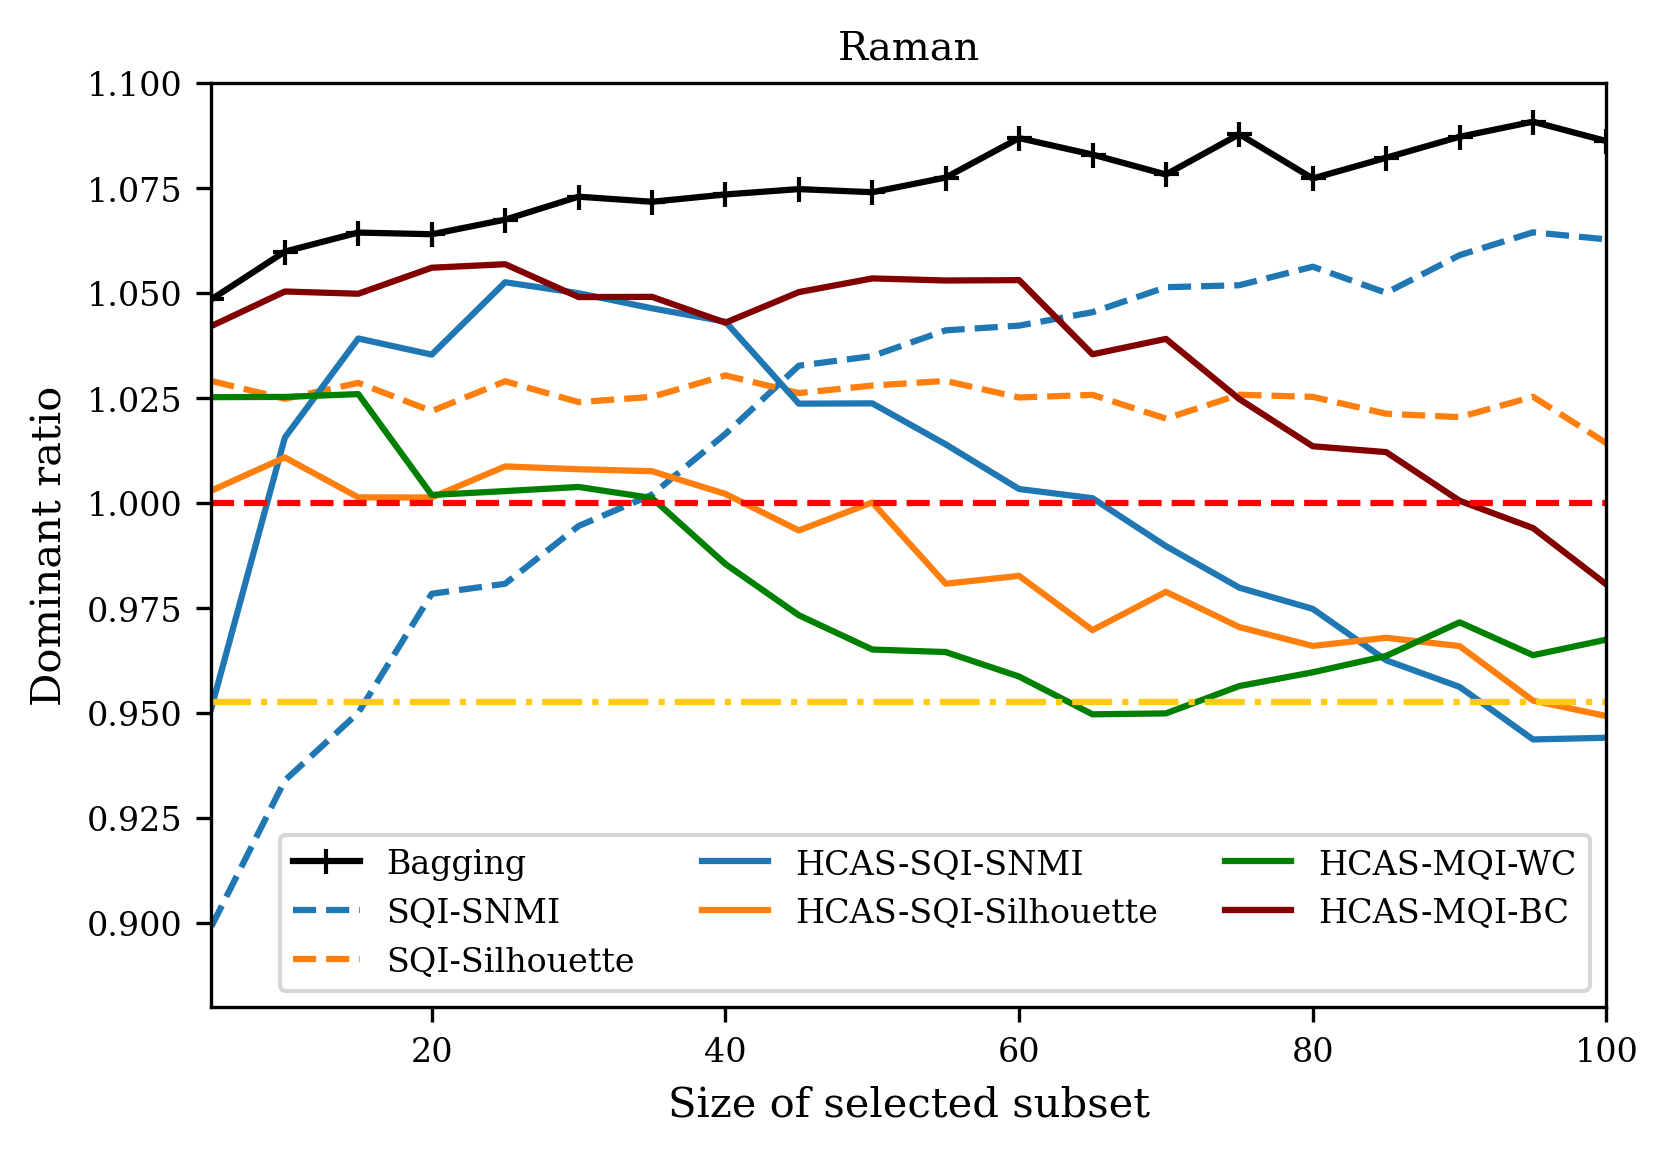

In [112]:
print("Dominant ratio")
num=range(5,105,5)
fig = plt.figure(figsize=(6,4), dpi=300)
plt.rc('font', family='serif', size = 8)

plt.xlabel('Size of selected subset',fontsize=10)
plt.ylabel('Dominant ratio',fontsize=10)
plt.title("Raman")
plt.xlim(5,100,5)
plt.ylim(0.88,1.10,0.1)
plt.plot(num,df_final_average.loc["Bagging_Dominant_ratio"], label = "Bagging", color="black",marker="+",ms=6)
plt.plot(num,df_final_average.loc["SQI_SNMI_Dominant_ratio"], label = "SQI-SNMI", linestyle="--",color="#1f77b4")
plt.plot(num,df_final_average.loc["SQI_Silhouette_Dominant_ratio"], label = "SQI-Silhouette", linestyle="--",color="#ff7f0e")
plt.plot(num,df_final_average.loc["HCAS_SQI_SNMI_Dominant_ratio"], label = "HCAS-SQI-SNMI", color="#1f77b4")
plt.plot(num,df_final_average.loc["HCAS_SQI_Silhouette_Dominant_ratio"], label = "HCAS-SQI-Silhouette", color="#ff7f0e")
plt.plot(num,df_final_average.loc["HCAS_MQI_WC_Dominant_ratio"], label = "HCAS-MQI-WC", color="green")
plt.plot(num,df_final_average.loc["HCAS_MQI_BC_Dominant_ratio"], label = "HCAS-MQI-BC", color="#820000")

plt.axhline(y=1.00, color="r", linestyle="--")
plt.axhline(y=HCAS_MQI_DC_Dominant_ratio, color="#ffca13", linestyle="-.")

legend = plt.legend(loc='lower right', shadow=False, fontsize=8,ncol=3)
plt.show()
fig.savefig(output_path+filename+" CES Strategies final comparison Dominant ratio.png", bbox_inches="tight", dpi = 300)

### Paired T-test

In [3]:
from scipy import stats

In [8]:
def get_T_test_data(n):
    df = pd.read_csv(dataset_path+filename+".csv")
    Y=df.Class
    
    NMI_CSPA_EN = []
    NMI_HBGF_EN = []
    runs = []
    for i in range(n):
        print("run_"+str(i+1))
        
        result_i = pd.read_csv(output_path+filename+" BC library run_"+str(i+1)+".csv", index_col="Unnamed: 0")
        Y_CSPA_EN = result_i.loc["CSPA_EN"]
        NMI_CSPA_EN.append(normalized_mutual_info_score(Y,Y_CSPA_EN)) 

        run_i = pd.read_csv(output_path+filename+" CES strategies final comparison run_"+str(i+1)+".csv",index_col="Unnamed: 0")
        runs.append(run_i)
    
    print("Total of ", len(runs), "iterations to avearge")
    
    df_concat=pd.concat(runs)
    
    return df_concat, NMI_CSPA_EN

In [31]:
filename="0.971 scaled DFT 6-311++G(d,p) IR dataset"
row_idx = ['SQI_SNMI_NMI', 'SQI_Silhouette_NMI','Bagging_NMI','HCAS_SQI_SNMI_NMI','HCAS_SQI_Silhouette_NMI','HCAS_MQI_WC_NMI','HCAS_MQI_BC_NMI']
column_idx = [3,7,11,15,19]
df_Test_Data, NMI_CSPA = get_T_test_data(20)
print(np.mean(NMI_CSPA), np.std(NMI_CSPA))
shapiro_test = stats.shapiro(NMI_CSPA)
if shapiro_test.pvalue >=0.05:
    print("YES, data is normally distributed")
else:
    print("No, data is non-normally distributed, t test is not appopriate")

run_1
run_2
run_3
run_4
run_5
run_6
run_7
run_8
run_9
run_10
run_11
run_12
run_13
run_14
run_15
run_16
run_17
run_18
run_19
run_20
Total of  20 iterations to avearge
0.6177309114945178 0.0156344719301077
YES, data is normally distributed


In [32]:
for i in range(7):
    print("*****",row_idx[i],"*****")

    df_tmp_1 = df_Test_Data.loc[row_idx[i]]
    df_tmp_2 = df_tmp_1.iloc[:,column_idx]
    print(df_tmp_2.describe())
    
    for j in range(5):
        shapiro_test = stats.shapiro(df_tmp_2.iloc[:,j])
        if shapiro_test.pvalue >=0.05:
            print("YES, data is normally distributed")
        else:
            print("No, data is non-normally distributed, t test is not appopriate")
        
        print("**")
        t_test = stats.ttest_rel(NMI_CSPA,df_tmp_2.iloc[:,j])
        print(t_test.pvalue)
        if t_test.pvalue >= 0.05:
            print("p-value is not less than 0.05, fail to reject the null hypothesis, not statistically significant")
        else:
            print("YES!")
            print("p-value is less than 0.05, reject the null hypothesis, data is statistically significant")

***** SQI_SNMI_NMI *****
              20         40         60         80        100
count  20.000000  20.000000  20.000000  20.000000  20.000000
mean    0.614537   0.625855   0.631274   0.634984   0.636342
std     0.011764   0.011821   0.007831   0.007047   0.008379
min     0.594678   0.590336   0.614904   0.617347   0.615089
25%     0.606972   0.619191   0.629912   0.631981   0.633526
50%     0.616017   0.626867   0.633815   0.635989   0.637965
75%     0.622247   0.635363   0.635999   0.640301   0.641151
max     0.639174   0.638864   0.643379   0.647082   0.650468
YES, data is normally distributed
**
0.5422832996911898
p-value is not less than 0.05, fail to reject the null hypothesis, not statistically significant
No, data is non-normally distributed, t test is not appopriate
**
0.06963360198375769
p-value is not less than 0.05, fail to reject the null hypothesis, not statistically significant
No, data is non-normally distributed, t test is not appopriate
**
0.003776377270012366
YES